In [133]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [134]:
image = cv2.imread('images/00195.jpg')
hsv_img = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)

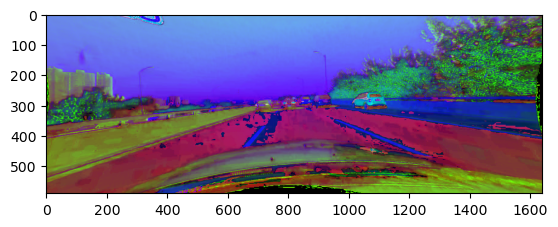

In [135]:
plt.imshow(hsv_img,cmap='hsv')
plt.show()

In [136]:
h_slice = hsv_img[:,:,0]
s_slice = hsv_img[:,:,1]
v_slice = hsv_img[:,:,2]

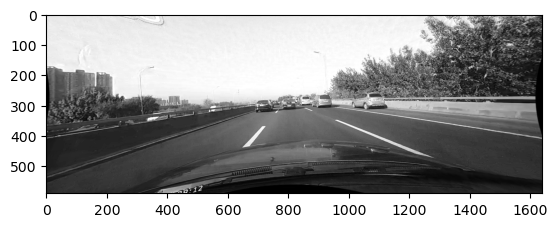

In [137]:
plt.imshow(v_slice,cmap='gray')
plt.show()

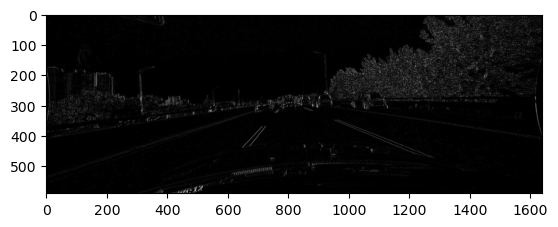

In [138]:
sobel_x = cv2.Sobel(v_slice, cv2.CV_64F, 1, 0)
sobel_x = np.absolute(sobel_x)
sobel_x = np.uint8(255*sobel_x/np.max(sobel_x))
plt.imshow(sobel_x,cmap='gray')
plt.show()

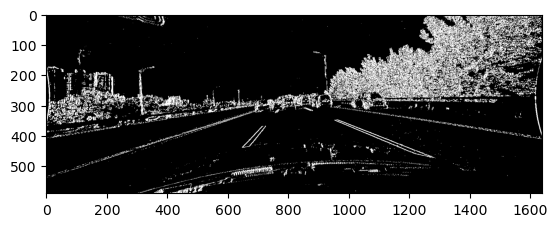

In [139]:
sobel_x_binary = np.zeros_like(sobel_x)
sobel_x_binary[(sobel_x >= 15) & (sobel_x <= 255)] = 1
plt.imshow(sobel_x_binary,cmap='gray')
plt.show()

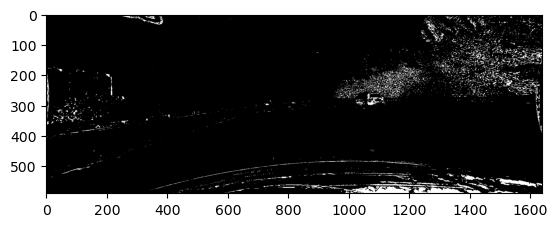

In [140]:
s_slice_binary = np.zeros_like(s_slice)
s_slice_binary[(s_slice >= 180) & (s_slice <= 255)] = 1
plt.imshow(s_slice_binary,cmap='gray')
plt.show()

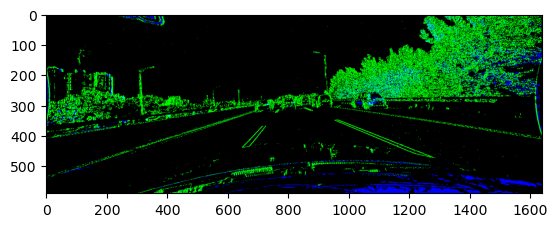

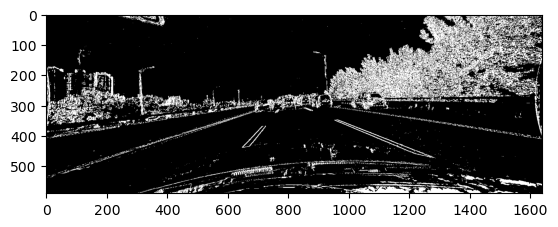

(590, 1640)


In [141]:
color_binary = np.dstack((np.zeros_like(sobel_x_binary), sobel_x_binary, s_slice_binary)) * 255
plt.imshow(color_binary,cmap='gray')
plt.show()
    
combined_binary = np.zeros_like(sobel_x_binary)
combined_binary[(s_slice_binary == 1) | (sobel_x_binary == 1)] = 1
plt.imshow(combined_binary,cmap='gray')
plt.show()

print(combined_binary.shape)

In [142]:
def roi_warp(img,
             src=np.float32([(0.37,0.45),(0.8,0.45),(0.24,0.75),(1,0.75)]),
             dst=np.float32([(0,0), (1, 0), (0,1), (1,1)]),
             dst_size=(1640,590)):
    x_lim = img.shape[1]
    y_lim = img.shape[0]
    img_sz = [(x_lim, y_lim)]
    img_sz = np.float32(img_sz)
    src = src* img_sz
    image = img
    dst_sz = np.float32(dst_size)
    dst = dst * dst_sz
    P = cv2.getPerspectiveTransform(src, dst)
    # return warped image
    warped = cv2.warpPerspective(img, P, dst_size)
    return warped

def warp_inv(img,
            src=np.float32([(0,0), (1, 0), (0,1), (1,1)]),
            dst=np.float32([(0.37,0.69),(0.8,0.69),(0.1,1),(1,1)]),
            dst_size=(1640,590)):
    
    x_lim = img.shape[1]
    y_lim = img.shape[0]
    img_sz = [(x_lim, y_lim)]
    img_sz = np.float32(img_sz)
    src = src* img_sz
    dst_sz = np.float32(dst_size)
    dst = dst * dst_sz
    P = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, P, dst_size)
    # return warped image
    return warped

In [143]:
num_windows=9 
margin=150 
min_pix = 1 

In [144]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

left_ind_a = []
left_ind_b = []
left_ind_c = []
right_a = []
right_b = []
right_c = []

def sliding_window(img, 
                    nwindows=9, 
                    margin=150, 
                    minpix = 1, 
                    draw_windows=True):

    histogram = get_hist(img)
    global left_ind_a, left_ind_b, left_ind_c,right_a, right_b, right_c
    left_lane_inds = []
    right_lane_inds = []
    left_fit_= np.empty(3)
    img_tup = (img, img, img)
    right_fit_ = np.empty(3)
    out_img = np.dstack(img_tup)
    out_img = out_img*255

    midpoint = histogram.shape[0]/2
    midpoint = int(midpoint)
    leftx_base=histogram[:midpoint]
    leftx_base = np.argmax(leftx_base)
    rightx_base = histogram[midpoint:]
    rightx_base = np.argmax(rightx_base)
    rightx_base = rightx_base + midpoint

    window_height = img.shape[0]/nwindows
    window_height = int(window_height)
   
    nonzero = img.nonzero()
    nonzeroy = nonzero[0]
    nonzeroy = np.array(nonzeroy)
    nonzerox = nonzero[1]
    nonzerox = np.array(nonzerox)
   
    leftx_current = leftx_base

    rightx_current = rightx_base
    
    for window in range(nwindows):

        win_y_low = img.shape[0]
        kw = (window+1)*window_height
        win_y_low = win_y_low - kw
        kw = window*window_height
        win_y_high = img.shape[0]
        win_y_high = win_y_high - kw
        win_xleft_low = leftx_current
        win_xleft_low = win_xleft_low - margin
        win_xleft_high = leftx_current
        win_xleft_high = win_xleft_high + margin
        win_xright_low = rightx_current 
        win_xright_low = win_xright_low - margin
        win_xright_high = rightx_current
        win_xright_high = win_xright_high + margin
        
        check_dw = draw_windows == True
        if check_dw:
            tup1 = (win_xleft_low,win_y_low)
            tup2 = (win_xleft_high,win_y_high)
            cv2.rectangle(out_img,tup1,tup2,(100,255,255), 3)
            tup1 = (win_xright_low,win_y_low)
            tup2 = (win_xright_high,win_y_high)
            cv2.rectangle(out_img,tup1,tup2,(100,255,255), 3) 

        good_left_inds = (nonzeroy >= win_y_low) 
        good_left_inds = good_left_inds & (nonzeroy < win_y_high) 
        good_left_inds = good_left_inds & (nonzerox >= win_xleft_low) 
        good_left_inds = good_left_inds &  (nonzerox < win_xleft_high)
        good_left_inds = good_left_inds.nonzero()[0]
        good_right_inds = (nonzeroy >= win_y_low) 
        good_right_inds = good_right_inds & (nonzeroy < win_y_high) 
        good_right_inds = good_right_inds & (nonzerox >= win_xright_low) 
        good_right_inds = good_right_inds &  (nonzerox < win_xright_high)
        good_right_inds = good_right_inds.nonzero()[0]

        left_lane_inds.append(good_left_inds)
        check_px1 = len(good_left_inds) > minpix
        right_lane_inds.append(good_right_inds)
        check_px2 = len(good_right_inds) > minpix

        if check_px1:
            leftx_current = nonzerox[good_left_inds]
            leftx_current = np.mean(leftx_current)
            leftx_current = int(leftx_current)
        if check_px2:        
            rightx_current = nonzerox[good_right_inds]
            rightx_current = np.mean(rightx_current)
            rightx_current = int(rightx_current)

    left_lane_inds = np.concatenate(left_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    right_lane_inds = np.concatenate(right_lane_inds)
    rightx = nonzerox[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    righty = nonzeroy[right_lane_inds]
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_ind_a.append(left_fit[0])
    left_fit_[0] = np.mean(left_ind_a[-10:])
    left_ind_b.append(left_fit[1])
    left_fit_[1] = np.mean(left_ind_b[-10:])
    left_ind_c.append(left_fit[2])
    left_fit_[2] = np.mean(left_ind_c[-10:])
    
    right_a.append(right_fit[0])
    right_fit_[0] = np.mean(right_a[-10:])
    right_b.append(right_fit[1])
    right_fit_[1] = np.mean(right_b[-10:])
    right_c.append(right_fit[2])
    right_fit_[2] = np.mean(right_c[-10:])

    img_shp1 = img.shape[0]-1
    ploty = np.linspace(0, img_shp1, img_shp1 + 1)

    left_fitx = left_fit_[0]*ploty**2 
    left_fitx = left_fitx + left_fit_[1]*ploty 
    left_fitx = left_fitx + left_fit_[2]

    right_fitx = right_fit_[0]*ploty**2 
    right_fitx = right_fitx + right_fit_[1]*ploty 
    right_fitx = right_fitx + right_fit_[2]

    x_left = nonzeroy[left_lane_inds]
    y_left = nonzerox[left_lane_inds]
    out_img[x_left, y_left] = [255, 0, 100]
    x_right = nonzeroy[right_lane_inds]
    y_right = nonzerox[right_lane_inds]
    out_img[x_right,y_right ] = [0, 100, 255]
    out_tup1 = (left_fitx, right_fitx)
    out_tup2 = (left_fit_, right_fit_)
    return out_img, out_tup1, out_tup2, ploty


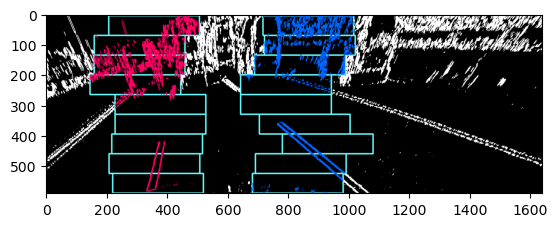

In [145]:
mask_img = roi_warp(sobel_x_binary)
out_img, curves, lanes, ploty = sliding_window(mask_img)
plt.imshow(out_img)
plt.show()

In [146]:
def draw_lanes(img, left_fit, right_fit):
    img_shp = img.shape[0]-1
    ploty = np.linspace(0, img_shp, img_shp+1)
    color_img = np.zeros_like(img)
    left = np.vstack([left_fit, ploty])
    left = [np.transpose(left)]
    left =  np.array(left)
    right = np.vstack([right_fit, ploty])
    right = np.transpose(right)
    right = [np.flipud(right)]
    right = np.array(right)

    points = np.hstack((left, right))
    pts = np.int_(points)
    cv2.fillPoly(color_img, pts, (0,200,255))
    wt = 0.7
    inv_perspective = warp_inv(color_img)
    param = 0.0
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, wt, int(param))

    return inv_perspective

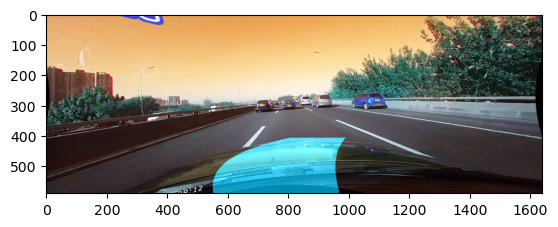

In [147]:
lane_img = draw_lanes(image, curves[0],curves[1])
plt.imshow(lane_img)
plt.show()